# Calibration History

- 2024-08-19
  - Device 01 PM2.5: 7.7 to 8.5 (+0.8, or ~10%)
  - Device 02 PM2.5: 5.3 to 5.1 (-0.2 or ~5%)
- 2024-08-20
  - Device 01 PM2.5: 7.5 to 7.9 (+0.4, or ~5%)
  - Device 02 PM2.5: 6.8 to 7.3 (+0.5 or ~8%)
- 2024-08-21
  - Device 01 PM2.5: 7.5 to 7.1 (+0.4, or ~5%)
  - Device 02 PM2.5: Not adjusted

## Methodology
The calibration mathodology is to simply place the devices side-by-side in the same space, over a period of 12-24 hours, such that they are measuring the same air.

![Devices Side-By-Side](doc/calibration.jpg)

The recorded PM<sub>2.5</sub> values are charted, and a trendline generated comparing two of the devices, producing an equation of the form:

> (device X PM<sub>2.5</sub>) = (device Y PM<sub>2.5</sub>) × (difference)

Ideally, the value of `(difference)` is 1 (i.e., both devices are recording identical values), but if it's not, the device is adjusted, and this process repeated until the difference is sufficiently close.

Calibration is done both indoors and outdoors, the rationale being:
- Indoor air tends to be more still, resulting in less variance, and allowing for finer calibration
- Outdoor air in contrast, is expect to have more variance, allowing us to calibrate across a wider range

Given that Device 3 PM<sub>2.5</sub> values were the median value out of the box, Devices 1 & 2 have been adjusted to get them as close to Device 3 as possible. Keeping in mind the goal is to measure relative air quality between the various spaces, rather than to determine the absolute air quality of any one space.

In [1]:
import datetime
import pandas as pd
import statsmodels.formula.api as sm
from functools import reduce
from typing import Sequence

In [2]:
def display_correlation(df: pd.DataFrame, tgt: str, src: str):
    regression = sm.ols(formula=f"{tgt} ~ {src} -1", data=df).fit()
    coefficient = regression.params.values[0]
    max_src = df[src].max()
    ax = df.plot.scatter(tgt, src)
    ax.plot([0, max_src * coefficient], [0, max_src], color="0.9", linestyle="dotted")
    ax.text(x=0, y=max_src - 1, s=f"{tgt} = {src} × {coefficient:.4f} (r²={regression.rsquared:.4f})")

def display_data_and_correlations(
    df: pd.DataFrame, tgt: str, srcs: Sequence[str], start_incl: datetime.datetime, end_excl: datetime.datetime
):
    times = [start_incl + datetime.timedelta(hours=h) for h in range(int((end_excl - start_incl).total_seconds() / 60 / 60))]
    df_within_time = df.loc[(slice(None), times), ["Location", "PM2.5(ug/m³)"]]
    df_device_grouped = df_within_time.groupby(level=0)
    dfs = [
        grp.reset_index().drop("Device", axis=1).set_index(["Location", "Time"]).rename(columns={"PM2.5(ug/m³)": f"Device{dev}"})
        for dev, grp in df_device_grouped
    ]
    pm25_df = reduce(lambda l, r: l.join(r), dfs)
    
    display(pm25_df)
    pm25_df.reset_index(level=0, drop=True).resample("5min").interpolate(method="cubic").plot()
    for src in srcs:
        display_correlation(pm25_df, tgt, src)

In [3]:
%run "Common.ipynb"

Time                                   Floor  \
                             min                       max count nunique   
Device                                                                     
01     2024-08-18 17:00:00+08:00 2024-08-23 14:00:00+08:00   111       1   
02     2024-08-18 17:00:00+08:00 2024-08-23 14:00:00+08:00   112       1   
03     2024-08-17 20:00:00+08:00 2024-08-23 14:00:00+08:00   129       1   

       Location  
        nunique  
Device           
01            2  
02            3  
03            3

## Calibration Run #1
August 18, 2024 5pm to August 19, 2024, 10am

Device01  Device02  Device03
Location Time                                                   
Unit 210 2024-08-18 17:00:00+08:00       8.5       9.5       9.8
         2024-08-18 18:00:00+08:00       8.5      10.0      10.3
         2024-08-18 19:00:00+08:00       8.1       9.7       9.8
         2024-08-18 20:00:00+08:00       9.2      10.5       9.5
         2024-08-18 21:00:00+08:00      10.2      11.6      10.1
         2024-08-18 22:00:00+08:00      10.2      11.8      10.7
         2024-08-18 23:00:00+08:00       8.8      10.8      10.7
         2024-08-19 00:00:00+08:00       6.7       7.9       8.0
         2024-08-19 01:00:00+08:00       5.4       6.5       6.3
         2024-08-19 02:00:00+08:00       4.3       4.7       4.5
         2024-08-19 03:00:00+08:00       4.0       4.5       4.2
         2024-08-19 04:00:00+08:00       4.1       4.4       4.0
         2024-08-19 05:00:00+08:00       4.4       4.6       4.2
         2024-08-19 06:00:00+08:00       4.4       4.7       4.4
         2024-08-19 07:00:00+08:00       4.3       4.8       5.0
         2024-08-19 08:00:00+08:00       5.1       5.0       6.1
         2024-08-19 09:00:00+08:00      14.6      15.7      14.9
         2024-08-19 10:00:00+08:00      11.5      13.0      12.5

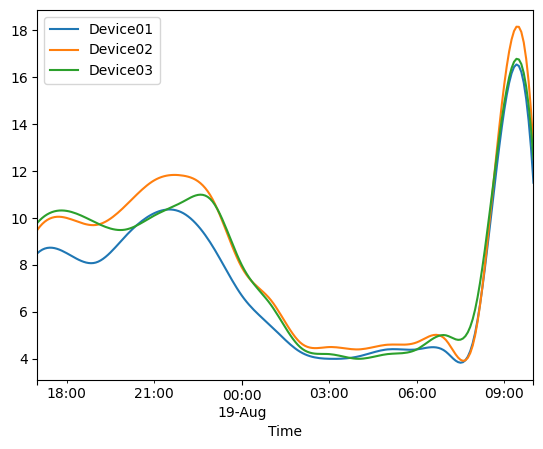

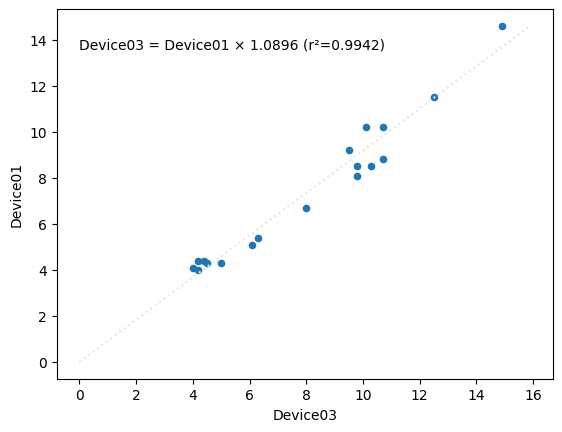

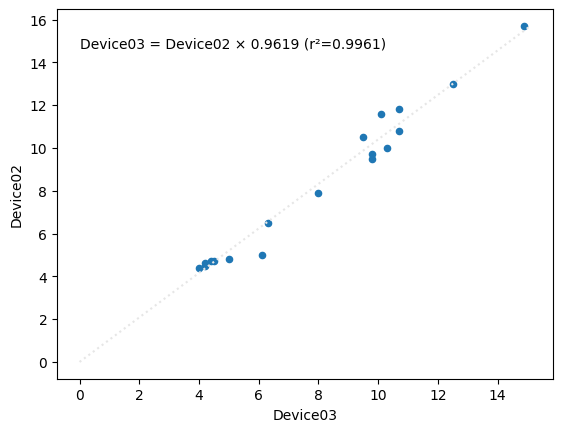

In [4]:
start_incl = datetime.datetime.fromisoformat("2024-08-18T17:00:00+08.00")
end_excl = datetime.datetime.fromisoformat("2024-08-19T11:00:00+08.00")

display_data_and_correlations(df, "Device03", ["Device01", "Device02"], start_incl, end_excl)

## Calibration Run #2
August 20, 2024 1am to August 20, 2024, 12pm

Device01  Device02  Device03
Location Time                                                   
Unit 210 2024-08-20 01:00:00+08:00       3.1       3.6       3.8
         2024-08-20 02:00:00+08:00       3.5       3.7       4.0
         2024-08-20 03:00:00+08:00       3.0       3.2       3.7
         2024-08-20 04:00:00+08:00       2.8       3.0       3.5
         2024-08-20 05:00:00+08:00       2.8       2.7       3.6
         2024-08-20 06:00:00+08:00       3.0       2.9       3.5
         2024-08-20 07:00:00+08:00       3.3       3.1       3.5
         2024-08-20 08:00:00+08:00       3.4       3.3       3.8
         2024-08-20 09:00:00+08:00       3.6       3.7       4.1
         2024-08-20 10:00:00+08:00      10.6       9.2      10.9
         2024-08-20 11:00:00+08:00       9.1       9.1       9.1
         2024-08-20 12:00:00+08:00       6.1       6.7       5.9

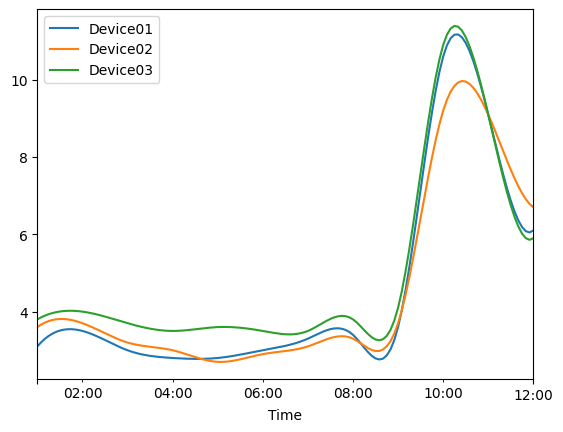

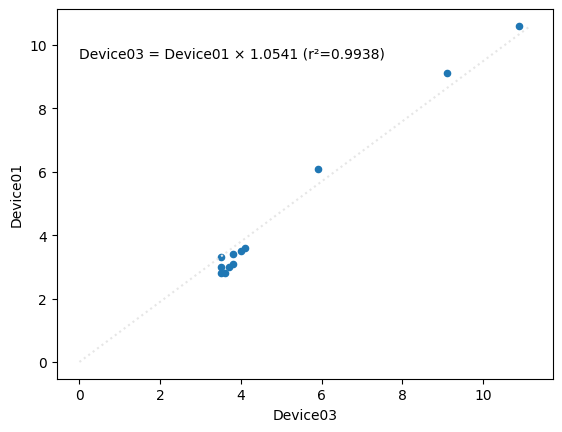

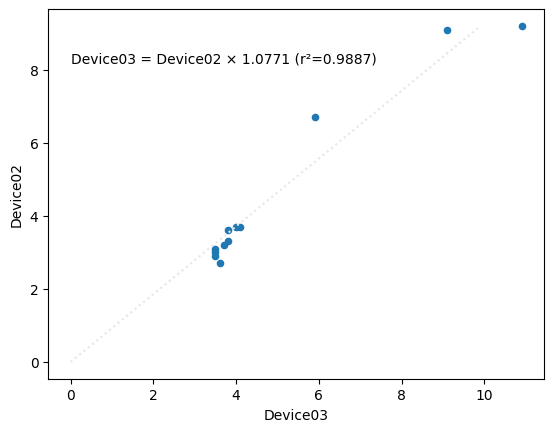

In [5]:
start_incl = datetime.datetime.fromisoformat("2024-08-20T01:00:00+08.00")
end_excl = datetime.datetime.fromisoformat("2024-08-20T13:00:00+08.00")

display_data_and_correlations(df, "Device03", ["Device01", "Device02"], start_incl, end_excl)

## Calibration Run #3
August 20, 2024 1pm to August 21, 2024, 3am

Note: Devices rebooted August 20, 2024 7:20pm as displayed numbers were diverging

Device01  Device02  Device03
Location Time                                                   
Patio    2024-08-20 13:00:00+08:00      10.3       8.8      10.9
         2024-08-20 14:00:00+08:00       6.9       7.3       6.5
         2024-08-20 15:00:00+08:00       6.1       6.7       6.0
         2024-08-20 16:00:00+08:00      17.9      13.4      13.0
         2024-08-20 17:00:00+08:00       6.6       5.5       5.8
         2024-08-20 18:00:00+08:00      12.7       6.2       6.3
         2024-08-20 19:00:00+08:00      11.2       9.3       9.1
         2024-08-20 20:00:00+08:00      59.1      56.0      53.6
         2024-08-20 21:00:00+08:00      15.8      13.9      14.1
         2024-08-20 22:00:00+08:00      10.0       9.1       9.0
         2024-08-20 23:00:00+08:00       9.4       9.2       8.7
         2024-08-21 00:00:00+08:00       8.8       9.1       8.5
         2024-08-21 01:00:00+08:00       8.8       9.0       8.4
         2024-08-21 02:00:00+08:00       8.1       8.1       8.0
         2024-08-21 03:00:00+08:00       8.6       7.8       7.8

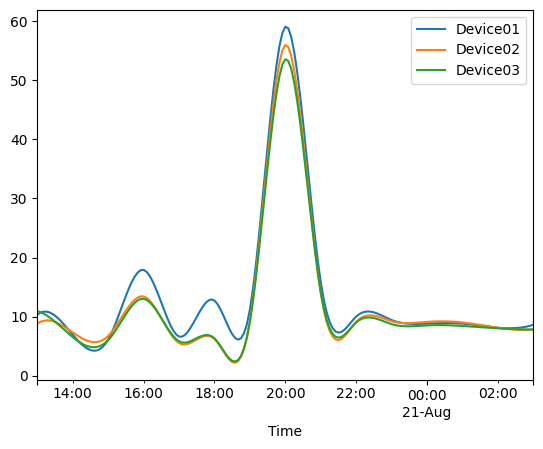

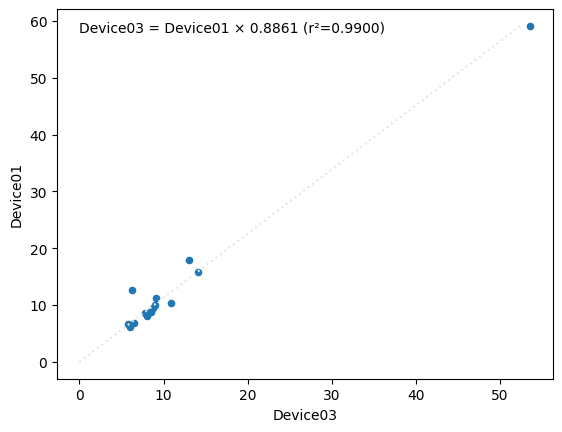

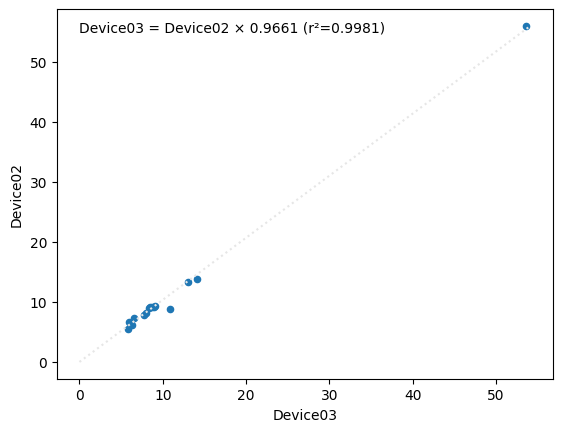

In [6]:
start_incl = datetime.datetime.fromisoformat("2024-08-20T13:00:00+08.00")
end_excl = datetime.datetime.fromisoformat("2024-08-21T04:00:00+08.00")

display_data_and_correlations(df, "Device03", ["Device01", "Device02"], start_incl, end_excl)